In [13]:
import pandas as pd
import glob
import json
import re
import os

In [14]:
files = glob.glob("/log/worker3/shieldx-client*")

In [15]:
def load_multiline_json(path, run_id):
    records = []
    buffer = ""
    with open(path, "r") as fh:
        for line in fh:
            line = line.strip()
            if not line:
                continue
            buffer += line
            if line.endswith("}"):   # fin de objeto JSON
                try:
                    rec = json.loads(buffer)
                    rec["source_file"] = path
                    rec["run_id"] = run_id
                    records.append(rec)
                except Exception as e:
                    print("❌ Error parseando:", buffer[:100], e)
                buffer = ""  # reset
    return records

In [16]:
all_records = []

for f in files:
    if f.endswith(".error"):
        continue
    run_id = os.path.basename(f)  # usar el nombre del archivo como id de corrida
    all_records.extend(load_multiline_json(f, run_id))

df = pd.DataFrame(all_records)
print("Columnas:", df.columns)
print("Total registros:", len(df))
print("Corridas distintas:", df['run_id'].nunique())

Columnas: Index(['timestamp', 'level', 'logger_name', 'thread_name', 'event', 'path',
       'status', 'time', 'source_file', 'run_id'],
      dtype='object')
Total registros: 155008
Corridas distintas: 16


In [17]:
df["operation"] = df["event"].str.extract(r"CLIENT\.([A-Z_]+)")
def extract_entity(path: str) -> str:
    if path is None:
        return "unknown"
    if re.search(r"/event-types/.*/triggers", path):
        return "event_type_trigger"
    if re.search(r"/triggers/.*/rules", path):
        return "rule_trigger"
    if re.search(r"/triggers/.*/children", path):
        return "trigger_trigger"
    return path.strip("/").split("/")[0]

df["entity"] = df["path"].apply(extract_entity)

In [18]:
def map_to_crud(op: str) -> str:
    if op is None:
        return "OTHER"
    op = op.upper()
    # Primero DELETE/UNLINK/REMOVE
    if any(word in op for word in ["DELETE", "UNLINK", "REMOVE"]):
        return "DELETE"
    # Luego CREATE/LINK
    if any(word in op for word in ["CREATE", "LINK"]):
        return "CREATE"
    # Después READ
    if any(word in op for word in ["GET", "LIST", "READ"]):
        return "READ"
    # Después UPDATE
    if "UPDATE" in op or "REPLACE" in op:
        return "UPDATE"
    return "OTHER"

df["crud"] = df["operation"].apply(map_to_crud)


In [19]:
df

,timestamp,level,logger_name,thread_name,event,path,status,time,source_file,run_id,operation,entity,crud
0,"2025-08-27 07:25:13,068",INFO,shieldx-client,MainThread,CLIENT.UPDATE_TRIGGER.RESPONSE,/triggers/TriggerBench-2140-b69975b7-d400-4cb4...,200,0.076215,/log/worker3/shieldx-client.2025-08-27_07-25,shieldx-client.2025-08-27_07-25,UPDATE_TRIGGER,triggers,UPDATE
1,"2025-08-27 07:25:13,137",INFO,shieldx-client,MainThread,CLIENT.DELETE_TRIGGER.RESPONSE,/triggers/TriggerBench-2140-b69975b7-d400-4cb4...,204,0.055639,/log/worker3/shieldx-client.2025-08-27_07-25,shieldx-client.2025-08-27_07-25,DELETE_TRIGGER,triggers,DELETE
2,"2025-08-27 07:25:13,199",INFO,shieldx-client,MainThread,CLIENT.CREATE_TRIGGER.RESPONSE,/triggers/,201,0.061553,/log/worker3/shieldx-client.2025-08-27_07-25,shieldx-client.2025-08-27_07-25,CREATE_TRIGGER,triggers,CREATE
3,"2025-08-27 07:25:13,257",INFO,shieldx-client,MainThread,CLIENT.GET_TRIGGER_BY_NAME.RESPONSE,/triggers/TriggerBench-2141-9c97fec2-54ed-40d1...,200,0.057592,/log/worker3/shieldx-client.2025-08-27_07-25,shieldx-client.2025-08-27_07-25,GET_TRIGGER_BY_NAME,triggers,READ
4,"2025-08-27 07:25:13,321",INFO,shieldx-client,MainThread,CLIENT.UPDATE_TRIGGER.RESPONSE,/triggers/TriggerBench-2141-9c97fec2-54ed-40d1...,200,0.063745,/log/worker3/shieldx-client.2025-08-27_07-25,shieldx-client.2025-08-27_07-25,UPDATE_TRIGGER,triggers,UPDATE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155003,"2025-08-27 06:39:45,732",INFO,shieldx-client,MainThread,CLIENT.CREATE_RULE.RESPONSE,/rules,201,0.056911,/log/worker3/shieldx-client.2025-08-27_06-29,shieldx-client.2025-08-27_06-29,CREATE_RULE,rules,CREATE
155004,"2025-08-27 06:39:45,787",INFO,shieldx-client,MainThread,CLIENT.GET_RULE_BY_ID.RESPONSE,/rules/68aefc91e15b2c290173dd84,200,0.054728,/log/worker3/shieldx-client.2025-08-27_06-29,shieldx-client.2025-08-27_06-29,GET_RULE_BY_ID,rules,READ
155005,"2025-08-27 06:39:45,847",INFO,shieldx-client,MainThread,CLIENT.UPDATE_RULE.RESPONSE,/rules/68aefc91e15b2c290173dd84,200,0.060046,/log/worker3/shieldx-client.2025-08-27_06-29,shieldx-client.2025-08-27_06-29,UPDATE_RULE,rules,UPDATE
155006,"2025-08-27 06:39:45,907",INFO,shieldx-client,MainThread,CLIENT.DELETE_RULE.RESPONSE,/rules/68aefc91e15b2c290173dd84,204,0.059675,/log/worker3/shieldx-client.2025-08-27_06-29,shieldx-client.2025-08-27_06-29,DELETE_RULE,rules,DELETE


In [20]:
crud_metrics = df.groupby(["entity", "crud"])["time"].agg(
    avg="mean", min="min", max="max", std="std", count="count"
).reset_index()

In [21]:
print("\n📊 Métricas totales:")
print(crud_metrics.sort_values(["entity", "crud"]))


📊 Métricas totales:
                entity    crud       avg       min       max       std  count
0          event-types  CREATE  0.064845  0.051663  0.260733  0.016553   5002
1          event-types  DELETE  0.066713  0.053111  0.230131  0.016817   5000
2          event-types    READ  0.064370  0.051378  0.251651  0.016602   5000
3   event_type_trigger  CREATE  0.067946  0.055543  0.247131  0.016967   5000
4   event_type_trigger  DELETE  0.066120  0.053023  0.262438  0.017248  15000
5   event_type_trigger    READ  0.065571  0.053506  0.247542  0.015841   5000
6   event_type_trigger  UPDATE  0.068368  0.055978  0.232129  0.017000   5000
7               events  CREATE  0.068923  0.054877  1.827017  0.034715   5000
8               events  DELETE  0.065382  0.052521  0.200861  0.016862   5000
9               events    READ  0.066202  0.053442  0.410307  0.018392   5000
10              events  UPDATE  0.068289  0.050702  0.418839  0.018733   5000
11        rule_trigger  CREATE  0.068005  0

In [22]:
crud_by_run = df.groupby(["run_id", "entity", "crud"])["time"].agg(
    avg="mean", min="min", max="max", std="std", count="count"
).reset_index()

print("\n📊 Métricas separadas por corrida:")
print(crud_by_run.head(20))


📊 Métricas separadas por corrida:
                             run_id              entity    crud       avg  \
0                    shieldx-client     trigger_trigger  CREATE  0.086455   
1                    shieldx-client     trigger_trigger  DELETE  0.080574   
2                    shieldx-client     trigger_trigger    READ  0.079465   
3                    shieldx-client            triggers    READ  0.076983   
4   shieldx-client.2025-08-27_05-17         event-types  CREATE  0.064720   
5   shieldx-client.2025-08-27_05-17         event-types  DELETE  0.066661   
6   shieldx-client.2025-08-27_05-17         event-types    READ  0.064388   
7   shieldx-client.2025-08-27_05-33         event-types  CREATE  0.064989   
8   shieldx-client.2025-08-27_05-33         event-types  DELETE  0.066792   
9   shieldx-client.2025-08-27_05-33         event-types    READ  0.064342   
10  shieldx-client.2025-08-27_05-33  event_type_trigger  CREATE  0.068410   
11  shieldx-client.2025-08-27_05-33  even

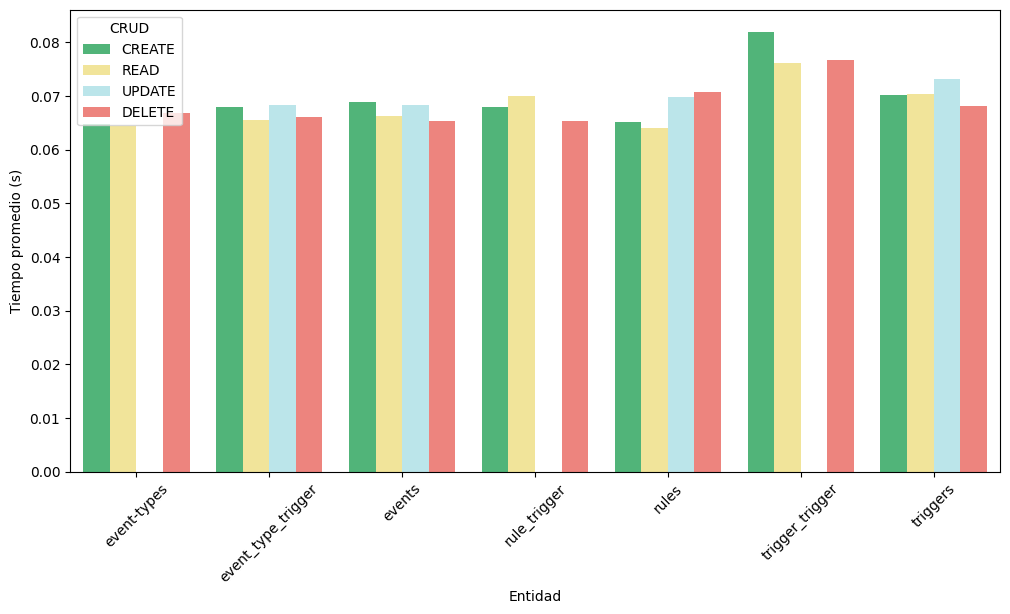

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reordenar niveles CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)

crud_avg = df.groupby(["entity", "crud"])["time"].mean().reset_index()
# Paleta de colores pastel
crud_palette = {
    "CREATE": "#40c576",   # verde pastel
    "READ":   "#ffee8c",   # amarillo pastel
    "UPDATE": "#b3ebf2",   # azul pastel
    "DELETE": "#ff746c"    # rojo pastel
}

# --- Barras promedio ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=crud_avg,
    x="entity",
    y="time",
    hue="crud",
    palette=crud_palette
)


plt.ylabel("Tiempo promedio (s)")
plt.xlabel("Entidad")
plt.xticks(rotation=45)
plt.legend(title="CRUD")
plt.show()



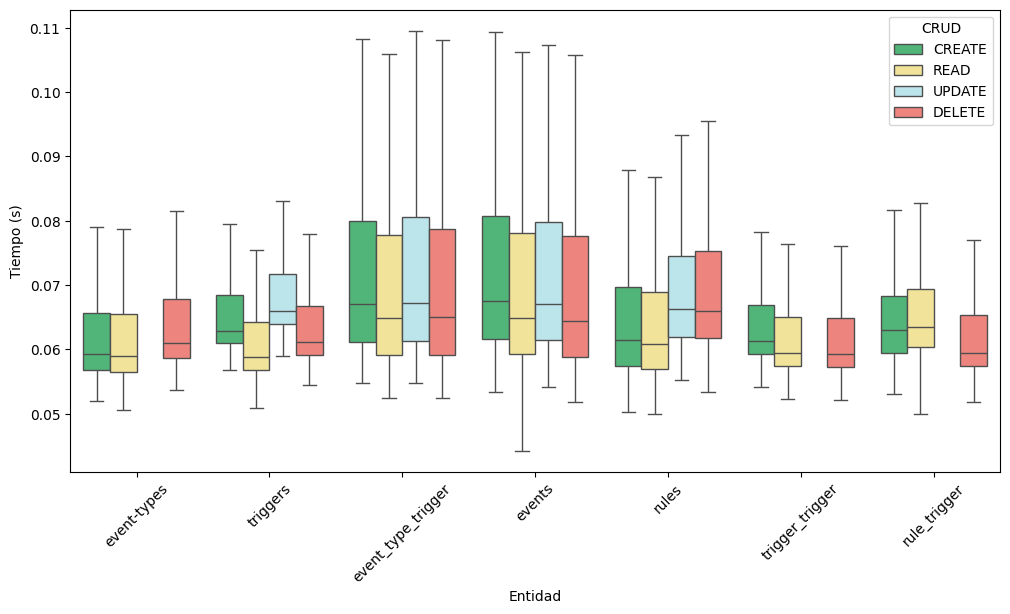

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mantener orden de CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)

# Paleta de colores pastel
crud_palette = {
    "CREATE": "#40c576",   # verde pastel
    "READ":   "#ffee8c",   # amarillo pastel
    "UPDATE": "#b3ebf2",   # azul pastel
    "DELETE": "#ff746c"    # rojo pastel
}

plt.figure(figsize=(12,6))
sns.boxplot(
    data=df[df["crud"] != "OTHER"],  # usar df completo
    x="entity",
    y="time",
    hue="crud",
    palette=crud_palette,
    showfliers=False
)


plt.ylabel("Tiempo (s)")
plt.xlabel("Entidad")
plt.xticks(rotation=45)
plt.legend(title="CRUD")
plt.show()


/tmp/ipykernel_3310/2180608819.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


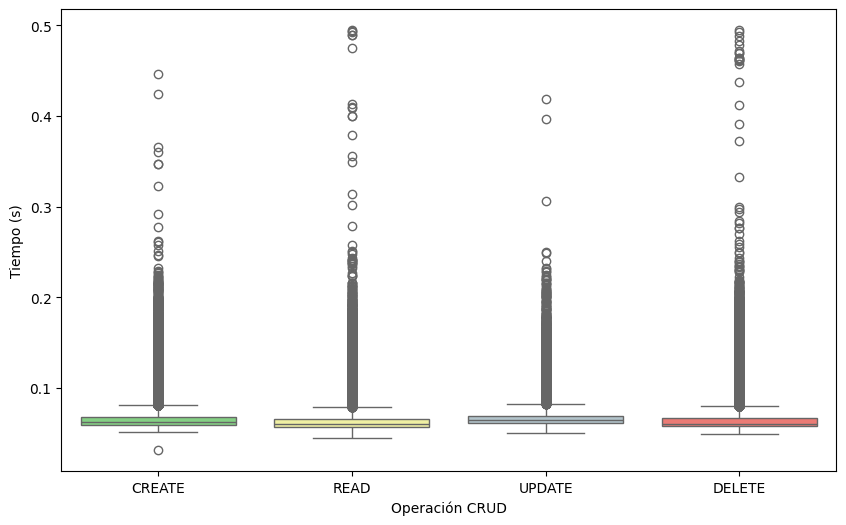

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo operaciones CRUD y tiempos menores a 2s
# Ordenar CRUD
df["crud"] = pd.Categorical(
    df["crud"],
    categories=["CREATE", "READ", "UPDATE", "DELETE"],
    ordered=True
)


df_crud_only = df[
    (df["crud"].isin(["CREATE", "READ", "UPDATE", "DELETE"])) &
    (df["time"] <= 0.5)
]



# Paleta de colores pastel
crud_palette = {
    "CREATE": "#77dd77",   # verde pastel
    "READ":   "#fdfd96",   # amarillo pastel
    "UPDATE": "#aec6cf",   # azul pastel
    "DELETE": "#ff6961"    # rojo pastel
}

plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_crud_only,
    x="crud",
    y="time",
    palette=crud_palette,
    showfliers=True   # si quieres ocultar todos los outliers pon False
)


plt.ylabel("Tiempo (s)")
plt.xlabel("Operación CRUD")
plt.show()
